In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

df = pd.read_pickle('/Users/melanieackerman/Metis/2. Linear Regression/Project 2 WNBA/shot_data.pkl')

In [63]:
# import NBA and plotting packages following https://eyalshafran.github.io/shot-chart.html
import NBAapi as nba
import matplotlib.pyplot as plt
import os
import sys
from scipy import misc
from scipy.stats.stats import pearsonr
%matplotlib inline 

ModuleNotFoundError: No module named 'NBAapi'

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7764 entries, 0 to 132
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   GRID_TYPE            7764 non-null   object
 1   GAME_ID              7764 non-null   object
 2   GAME_EVENT_ID        7764 non-null   int64 
 3   PLAYER_ID            7764 non-null   int64 
 4   PLAYER_NAME          7764 non-null   object
 5   TEAM_ID              7764 non-null   int64 
 6   TEAM_NAME            7764 non-null   object
 7   PERIOD               7764 non-null   int64 
 8   MINUTES_REMAINING    7764 non-null   int64 
 9   SECONDS_REMAINING    7764 non-null   int64 
 10  EVENT_TYPE           7764 non-null   object
 11  ACTION_TYPE          7764 non-null   object
 12  SHOT_TYPE            7764 non-null   object
 13  SHOT_ZONE_BASIC      7764 non-null   object
 14  SHOT_ZONE_AREA       7764 non-null   object
 15  SHOT_ZONE_RANGE      7764 non-null   object
 16  SHOT_DI

In [51]:
df.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,1020400002,28,100940,Diana Taurasi,1611661317,Phoenix Mercury,1,16,36,...,Left Side Center(LC),16-24 ft.,21,-123,179,1,1,20040520,PHO,SAC
1,Shot Chart Detail,1020400002,62,100940,Diana Taurasi,1611661317,Phoenix Mercury,1,12,42,...,Left Side(L),16-24 ft.,21,-179,120,1,0,20040520,PHO,SAC
2,Shot Chart Detail,1020400002,71,100940,Diana Taurasi,1611661317,Phoenix Mercury,1,11,57,...,Left Side(L),8-16 ft.,10,-90,59,1,0,20040520,PHO,SAC
3,Shot Chart Detail,1020400002,93,100940,Diana Taurasi,1611661317,Phoenix Mercury,1,9,17,...,Left Side(L),16-24 ft.,18,-161,91,1,0,20040520,PHO,SAC
4,Shot Chart Detail,1020400002,96,100940,Diana Taurasi,1611661317,Phoenix Mercury,1,8,39,...,Left Side Center(LC),16-24 ft.,22,-172,138,1,1,20040520,PHO,SAC


In [52]:
df.index.duplicated()

array([False, False, False, ...,  True,  True,  True])

In [53]:
df = df.reset_index(level=0)
df.head()

,index,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,0,Shot Chart Detail,1020400002,28,100940,Diana Taurasi,1611661317,Phoenix Mercury,1,16,...,Left Side Center(LC),16-24 ft.,21,-123,179,1,1,20040520,PHO,SAC
1,1,Shot Chart Detail,1020400002,62,100940,Diana Taurasi,1611661317,Phoenix Mercury,1,12,...,Left Side(L),16-24 ft.,21,-179,120,1,0,20040520,PHO,SAC
2,2,Shot Chart Detail,1020400002,71,100940,Diana Taurasi,1611661317,Phoenix Mercury,1,11,...,Left Side(L),8-16 ft.,10,-90,59,1,0,20040520,PHO,SAC
3,3,Shot Chart Detail,1020400002,93,100940,Diana Taurasi,1611661317,Phoenix Mercury,1,9,...,Left Side(L),16-24 ft.,18,-161,91,1,0,20040520,PHO,SAC
4,4,Shot Chart Detail,1020400002,96,100940,Diana Taurasi,1611661317,Phoenix Mercury,1,8,...,Left Side Center(LC),16-24 ft.,22,-172,138,1,1,20040520,PHO,SAC


In [61]:
# create column for season
import datetime

df['gamedate'] = pd.to_datetime(df['GAME_DATE'])
df['SEASON'] = pd.DatetimeIndex(df.gamedate).year

In [54]:
# what do the basic shot zones look like?
df['SHOT_ZONE_BASIC'].unique()

array(['Above the Break 3', 'Mid-Range', 'In The Paint (Non-RA)',
       'Left Corner 3', 'Right Corner 3', 'Restricted Area', 'Backcourt'],
      dtype=object)

Explanations from https://jr.nba.com/how-to-read-a-shot-chart/ 

- Corner 3: The small area on the left and right side of the court near the baseline. The 3-point line is a few inches closer to the basket in the corners.
- In The Paint: These are shots taken inside the key, the rectangular box close to the basket that measures 15 feet out to the free throw line and 16 feet wide.
- Restricted Area: The four-foot area directly surrounding the basket, marked by a semicircle in the paint.
- Mid-range: Any shot that comes outside the paint but inside the 3-point line.
- Above the Break 3: Any 3-pointer that is not taken from the corners.
- Backcourt: Any shot taken from beyond half court, mostly at the end of quarters to beat the clock.

In [55]:
# shot zone area can give even more detail
df['SHOT_ZONE_AREA'].unique()

array(['Left Side Center(LC)', 'Left Side(L)', 'Right Side(R)',
       'Back Court(BC)', 'Center(C)', 'Right Side Center(RC)'],
      dtype=object)

Combining information from SHOT_ZONE_AREA and SHOT_ZONE_RANGE will give the best picture of where each shot
was taken. The logistic regression will not handle interacting these terms, but the other models will. 

In [130]:
# check for class imbalance
df['SHOT_MADE_FLAG'].value_counts()

# looks good

0    4408
1    3356
Name: SHOT_MADE_FLAG, dtype: int64

In [131]:
# select features from raw data
temp = df[['SEASON','PERIOD', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_MADE_FLAG']]
temp.head()

,SEASON,PERIOD,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_MADE_FLAG
0,2004,1,Left Side Center(LC),16-24 ft.,1
1,2004,1,Left Side(L),16-24 ft.,0
2,2004,1,Left Side(L),8-16 ft.,0
3,2004,1,Left Side(L),16-24 ft.,0
4,2004,1,Left Side Center(LC),16-24 ft.,1


In [133]:
# get dummies for shot zone area and range category features
shots = pd.get_dummies(temp, prefix=['AREA', 'RANGE'], columns=['SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE'])
shots.head()

,SEASON,PERIOD,SHOT_MADE_FLAG,AREA_Back Court(BC),AREA_Center(C),AREA_Left Side Center(LC),AREA_Left Side(L),AREA_Right Side Center(RC),AREA_Right Side(R),RANGE_16-24 ft.,RANGE_24+ ft.,RANGE_8-16 ft.,RANGE_Back Court Shot,RANGE_Less Than 8 ft.
0,2004,1,1,0,0,1,0,0,0,1,0,0,0,0
1,2004,1,0,0,0,0,1,0,0,1,0,0,0,0
2,2004,1,0,0,0,0,1,0,0,0,0,1,0,0
3,2004,1,0,0,0,0,1,0,0,1,0,0,0,0
4,2004,1,1,0,0,1,0,0,0,1,0,0,0,0


In [134]:
# drop first level of dummies for reference category in logistic regression
shots_log = pd.get_dummies(temp, prefix=['AREA', 'RANGE'], 
                           columns=['SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE'], drop_first=True)
# back court is area reference category, 24+ ft. is range reference category
shots_log.head()

,SEASON,PERIOD,SHOT_MADE_FLAG,AREA_Center(C),AREA_Left Side Center(LC),AREA_Left Side(L),AREA_Right Side Center(RC),AREA_Right Side(R),RANGE_24+ ft.,RANGE_8-16 ft.,RANGE_Back Court Shot,RANGE_Less Than 8 ft.
0,2004,1,1,0,1,0,0,0,0,0,0,0
1,2004,1,0,0,0,1,0,0,0,0,0,0
2,2004,1,0,0,0,1,0,0,0,1,0,0
3,2004,1,0,0,0,1,0,0,0,0,0,0
4,2004,1,1,0,1,0,0,0,0,0,0,0


In [137]:
shots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7764 entries, 0 to 7763
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   SEASON                      7764 non-null   int64
 1   PERIOD                      7764 non-null   int64
 2   SHOT_MADE_FLAG              7764 non-null   int64
 3   AREA_Back Court(BC)         7764 non-null   uint8
 4   AREA_Center(C)              7764 non-null   uint8
 5   AREA_Left Side Center(LC)   7764 non-null   uint8
 6   AREA_Left Side(L)           7764 non-null   uint8
 7   AREA_Right Side Center(RC)  7764 non-null   uint8
 8   AREA_Right Side(R)          7764 non-null   uint8
 9   RANGE_16-24 ft.             7764 non-null   uint8
 10  RANGE_24+ ft.               7764 non-null   uint8
 11  RANGE_8-16 ft.              7764 non-null   uint8
 12  RANGE_Back Court Shot       7764 non-null   uint8
 13  RANGE_Less Than 8 ft.       7764 non-null   uint8
dtypes: int64

In [136]:
shots.describe()

,SEASON,PERIOD,SHOT_MADE_FLAG,AREA_Back Court(BC),AREA_Center(C),AREA_Left Side Center(LC),AREA_Left Side(L),AREA_Right Side Center(RC),AREA_Right Side(R),RANGE_16-24 ft.,RANGE_24+ ft.,RANGE_8-16 ft.,RANGE_Back Court Shot,RANGE_Less Than 8 ft.
count,7764.000000,7764.000000,7764.000000,7764.000000,7764.000000,7764.000000,7764.000000,7764.000000,7764.000000,7764.000000,7764.000000,7764.000000,7764.000000,7764.000000
mean,2011.375193,2.339001,0.432251,0.003993,0.404173,0.206337,0.139876,0.146059,0.099562,0.406878,0.209815,0.166667,0.003993,0.212648
std,5.000632,1.149282,0.495421,0.063066,0.490763,0.404701,0.346881,0.353188,0.299435,0.491283,0.407202,0.372702,0.063066,0.409207
min,2004.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2007.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2010.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2016.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,2021.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [135]:
# pickle the data
shots.to_pickle('/Users/melanieackerman/Metis/4. Classification/Project 4 WNBA/data/shots.pkl')
shots_log.to_pickle('/Users/melanieackerman/Metis/4. Classification/Project 4 WNBA/data/shots_log.pkl')

### Some EDA

In [122]:
# use combo of shot_zone_range and shot_zone_area to find overall shot zone, and use shot_made_flag to see if shot
# was made. then use groupby to get new df with zone based info on how many times Taurasi shot frome each zone

# this strategy is from https://eyalshafran.github.io/shot-chart.html

zones_list = [('Less Than 8 ft.', 'Center(C)'),
              ('8-16 ft.', 'Center(C)'),
              ('8-16 ft.', 'Left Side(L)'),
              ('8-16 ft.', 'Right Side(R)'),
              ('16-24 ft.', 'Center(C)'),
              ('16-24 ft.', 'Left Side Center(LC)'),
              ('16-24 ft.', 'Left Side(L)'),
              ('16-24 ft.', 'Right Side Center(RC)'),
              ('16-24 ft.', 'Right Side(R)'),
              ('24+ ft.', 'Center(C)'),
              ('24+ ft.', 'Left Side Center(LC)'),
              ('24+ ft.', 'Left Side(L)'),
              ('24+ ft.', 'Right Side Center(RC)'),
              ('24+ ft.', 'Right Side(R)'),
              ('Back Court Shot', 'Back Court(BC)')]

# create dataframe with season as index and the rest as columns
zones = df.groupby(['SHOT_ZONE_RANGE', 'SHOT_ZONE_AREA', 'SHOT_MADE_FLAG', 'SEASON']).size().unstack(fill_value=0)
zones.head()

SEASON                                               2004  2005  2006  2007  \
SHOT_ZONE_RANGE SHOT_ZONE_AREA       SHOT_MADE_FLAG                           
16-24 ft.       Center(C)            0                 24    20    38    36   
                                     1                 15    14    17    22   
                Left Side Center(LC) 0                 43    31    47    62   
                                     1                 21    14    32    40   
                Left Side(L)         0                 32    26    36    25   

SEASON                                               2008  2009  2010  2011  \
SHOT_ZONE_RANGE SHOT_ZONE_AREA       SHOT_MADE_FLAG                           
16-24 ft.       Center(C)            0                 36    36    43    42   
                                     1                 19    23    20    24   
                Left Side Center(LC) 0                 56    55    47    54   
                                     1                 40    30    35    25   
                Left Side(L)         0                 17    35    17    12   

SEASON                                               2012  2013  2014  2016  \
SHOT_ZONE_RANGE SHOT_ZONE_AREA       SHOT_MADE_FLAG                           
16-24 ft.       Center(C)            0                 11    42    25    25   
                                     1                  2    18    22    21   
                Left Side Center(LC) 0                  6    41    32    39   
                                     1                  4    26    26    19   
                Left Side(L)         0                  4     6    12     8   

SEASON                                               2017  2018  2019  2020  \
SHOT_ZONE_RANGE SHOT_ZONE_AREA       SHOT_MADE_FLAG                           
16-24 ft.       Center(C)            0                 40    21     1     4   
                                     1                 19    16     1     5   
                Left Side Center(LC) 0                 31    28     0     4   
                                     1                 26    19     0     7   
                Left Side(L)         0                 18    13     2     5   

SEASON                                               2021  
SHOT_ZONE_RANGE SHOT_ZONE_AREA       SHOT_MADE_FLAG        
16-24 ft.       Center(C)            0                  5  
                                     1                  6  
                Left Side Center(LC) 0                 18  
                                     1                  5  
                Left Side(L)         0                  2

In [105]:
# calculate number of games played per season and join with zones dataframe
gp = df.groupby('SEASON')['GAME_ID'].nunique().reset_index().rename(columns={'GAME_ID': 'GP'})
gp.head()

,SEASON,GP
0,2004,33
1,2005,33
2,2006,33
3,2007,41
4,2008,34


In [129]:
# per game averages in each season
zones/gp.GP.to_list()

SEASON                                                    2004      2005  \
SHOT_ZONE_RANGE SHOT_ZONE_AREA        SHOT_MADE_FLAG                       
16-24 ft.       Center(C)             0               0.727273  0.606061   
                                      1               0.454545  0.424242   
                Left Side Center(LC)  0               1.303030  0.939394   
                                      1               0.636364  0.424242   
                Left Side(L)          0               0.969697  0.787879   
                                      1               0.242424  0.484848   
                Right Side Center(RC) 0               0.878788  0.939394   
                                      1               0.454545  0.515152   
                Right Side(R)         0               0.424242  0.484848   
                                      1               0.272727  0.242424   
24+ ft.         Center(C)             0               0.000000  0.030303   
                                      1               0.090909  0.030303   
                Left Side Center(LC)  0               0.090909  0.272727   
                                      1               0.030303  0.151515   
                Left Side(L)          0               0.181818  0.242424   
                                      1               0.181818  0.090909   
                Right Side Center(RC) 0               0.181818  0.272727   
                                      1               0.000000  0.030303   
                Right Side(R)         0               0.060606  0.030303   
                                      1               0.060606  0.060606   
8-16 ft.        Center(C)             0               0.636364  0.333333   
                                      1               0.424242  0.242424   
                Left Side(L)          0               0.727273  0.484848   
                                      1               0.606061  0.424242   
                Right Side(R)         0               1.121212  1.000000   
                                      1               0.484848  0.727273   
Back Court Shot Back Court(BC)        0               0.030303  0.000000   
                                      1               0.030303  0.000000   
Less Than 8 ft. Center(C)             0               1.575758  1.212121   
                                      1               2.363636  1.454545   

SEASON                                                    2006      2007  \
SHOT_ZONE_RANGE SHOT_ZONE_AREA        SHOT_MADE_FLAG                       
16-24 ft.       Center(C)             0               1.151515  0.878049   
                                      1               0.515152  0.536585   
                Left Side Center(LC)  0               1.424242  1.512195   
                                      1               0.969697  0.975610   
                Left Side(L)          0               1.090909  0.609756   
                                      1               0.696970  0.585366   
                Right Side Center(RC) 0               1.575758  1.195122   
                                      1               0.787879  0.609756   
                Right Side(R)         0               0.363636  0.609756   
                                      1               0.484848  0.268293   
24+ ft.         Center(C)             0               0.242424  0.195122   
                                      1               0.090909  0.048780   
                Left Side Center(LC)  0               0.303030  0.317073   
                                      1               0.424242  0.146341   
                Left Side(L)          0               0.060606  0.170732   
                                      1               0.121212  0.170732   
                Right Side Center(RC) 0               0.212121  0.170732   
                                      1               0.060606  0.048780   
                Right Side(R)         0        

In [116]:
zones.loc[('Less Than 8 ft.', 'Center(C)')]


SEASON,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2016,2017,2018,2019,2020,2021
SHOT_MADE_FLAG,,,,,,,,,,,,,,,,,
0,52,40,62,43,57,58,54,43,7,66,35,40,22,28,4,16,21
1,78,48,98,95,88,100,69,62,6,95,63,56,39,64,2,18,22


In [ ]:
# sum over the missed and made shots to get total shots, divide by number of games played per season
for zone in zones_list:
    #calculate shots per game for specific zone and sort from highest to lowest
    shots_pg = (zones.loc[zone].sum(axis=1)/gp.loc['GP']).sort_values(0,ascending=False)
shots_pg.head()

In [5]:
test = df[['LOC_X', 'LOC_Y', 'SHOT_MADE_FLAG']]
test.head()

,LOC_X,LOC_Y,SHOT_MADE_FLAG
0,-123,179,1
1,-179,120,0
2,-90,59,0
3,-161,91,0
4,-172,138,1


In [6]:
y = test['SHOT_MADE_FLAG']
X = test[['LOC_X', 'LOC_Y']]
print(y.shape)
print(X.shape)

(7764,)
(7764, 2)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [10]:
print(X_train.shape)
print(X_test.shape)

(4658, 2)
(3106, 2)


In [11]:
print(y_train.shape)
print(y_test.shape)

(4658,)
(3106,)


In [14]:
# Train and test knn
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.5563425627817128


In [17]:
# search for an optimal value of K
from sklearn.model_selection import cross_val_score

k_range = list(range(1, 50))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.5450732396608685, 0.5822912935026336, 0.5643938489299314, 0.5875784473722618, 0.5708366503469595, 0.5901541084530775, 0.578564794544176, 0.5951763987846461, 0.5856486088444851, 0.599040553808595, 0.5897713250806034, 0.5950530058777481, 0.5882252650293888, 0.5964658878318672, 0.5888681022701641, 0.6016206928578062, 0.5905441892555294, 0.6005907601268425, 0.595051844922979, 0.6013613023922302, 0.5932465602568696, 0.6012319388608048, 0.5951783889928219, 0.5998157398930595, 0.5964692048454936, 0.6023923960779631, 0.5989130146346641, 0.6014896708195677, 0.5993022661837094, 0.6034226605102895, 0.6043243906645969, 0.6048395228807599, 0.6036812217224587, 0.6067708540646685, 0.6047118178561477, 0.6078034404065332, 0.6049693839642293, 0.6076740768751077, 0.6075465377011768, 0.6096054080590163, 0.6071589446589447, 0.612697694012127, 0.6107650360227679, 0.6141130637264659, 0.6099921718478419, 0.6107645384707241, 0.6105058114078733, 0.6130819700407328, 0.6103772771298545]


Text(0, 0.5, 'Cross-Validated Accuracy')

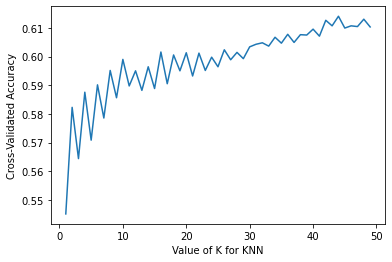

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot value of K for knn vs. cross-validated accuracy
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
# define paramter values to be searched
k_range = list(range(1, 100))
print(k_range)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [21]:
# create paramter grid: map the parameter names to values to be searched
param_grid = dict(n_neighbors=k_range)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]}


In [22]:
# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

In [23]:
# fit the grid with data
grid.fit(X, y)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(n_neighbors=49),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy')

In [24]:
# view the complete results
grid.cv_results_

{'mean_fit_time': array([0.00312555, 0.00244699, 0.00244999, 0.00244088, 0.00240285,
        0.00242162, 0.00247669, 0.00249469, 0.00243387, 0.0024405 ,
        0.00243855, 0.00242941, 0.00246959, 0.00248108, 0.00243638,
        0.00251136, 0.00245419, 0.00243068, 0.00244093, 0.00253046,
        0.0024169 , 0.00242431, 0.00242193, 0.00244429, 0.00246208,
        0.00242147, 0.00242238, 0.00249233, 0.00242419, 0.00246649,
        0.00251577, 0.00242195, 0.00249479, 0.00245423, 0.00251393,
        0.00245893, 0.00249474, 0.00242224, 0.00243006, 0.00247695,
        0.00242872, 0.00244527, 0.00248935, 0.0025573 , 0.00254083,
        0.0025538 , 0.00250492, 0.00252643, 0.00254941, 0.00248852,
        0.00249822, 0.0024636 , 0.00249188, 0.00251789, 0.00248067,
        0.00244198, 0.0024776 , 0.00248873, 0.00246413, 0.00252566,
        0.00247045, 0.00247049, 0.00244453, 0.00244451, 0.00246208,
        0.00246274, 0.00246887, 0.00267549, 0.00250306, 0.00244603,
        0.00251184, 0.0024915 ,

In [25]:
# examine best model
print('Best params: ', grid.best_params_)
print('Best estimator: ', grid.best_estimator_)
print('Best score: ', grid.best_score_)

Best params:  {'n_neighbors': 94}
Best estimator:  KNeighborsClassifier(n_neighbors=94)
Best score:  0.6209416338282319


In [42]:
# Use k=94
knn = KNeighborsClassifier(n_neighbors=94)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.6236316806181584


In [43]:
from sklearn.metrics import confusion_matrix, classification_report

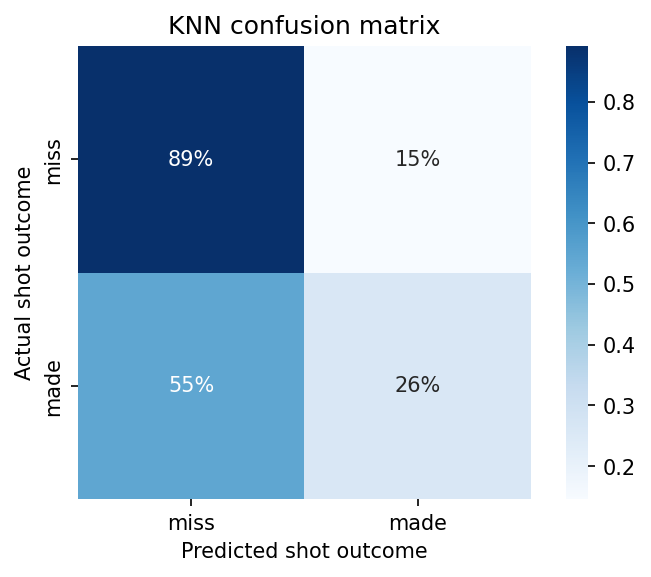

In [46]:
cfmatrix = confusion_matrix(y_test, y_pred)
plt.figure(dpi=150)
sns.heatmap(cfmatrix/cfmatrix.sum(axis=1), cmap=plt.cm.Blues, annot=True, square=True, fmt='.0%',
           xticklabels=['miss', 'made'], yticklabels=['miss', 'made'])
plt.xlabel('Predicted shot outcome')
plt.ylabel('Actual shot outcome')
plt.title('KNN confusion matrix')
plt.show()

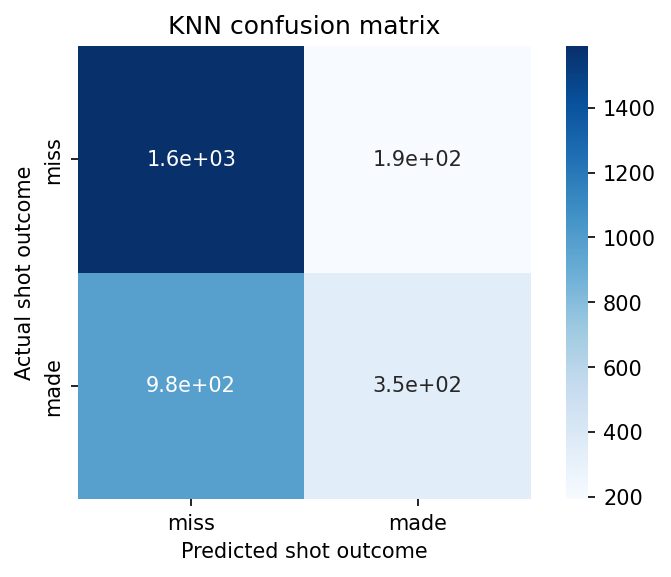

In [48]:
cfmatrix = confusion_matrix(y_test, y_pred)
plt.figure(dpi=150)
sns.heatmap(cfmatrix, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['miss', 'made'], yticklabels=['miss', 'made'])
plt.xlabel('Predicted shot outcome')
plt.ylabel('Actual shot outcome')
plt.title('KNN confusion matrix')
plt.show()

In [36]:
test2 = df2[['SHOT_DISTANCE', 'SHOT_MADE_FLAG']]

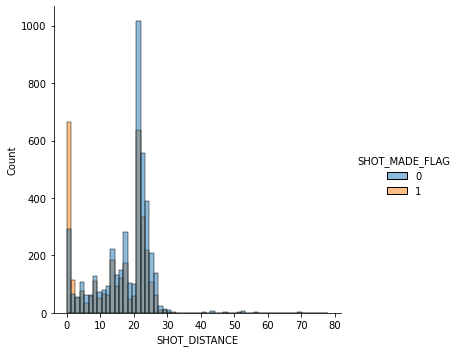

In [39]:
sns.displot(test2, x='SHOT_DISTANCE', hue='SHOT_MADE_FLAG')

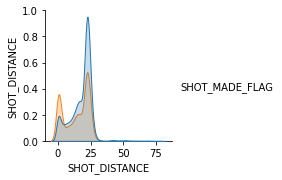

In [40]:
sns.pairplot(test2, hue='SHOT_MADE_FLAG')

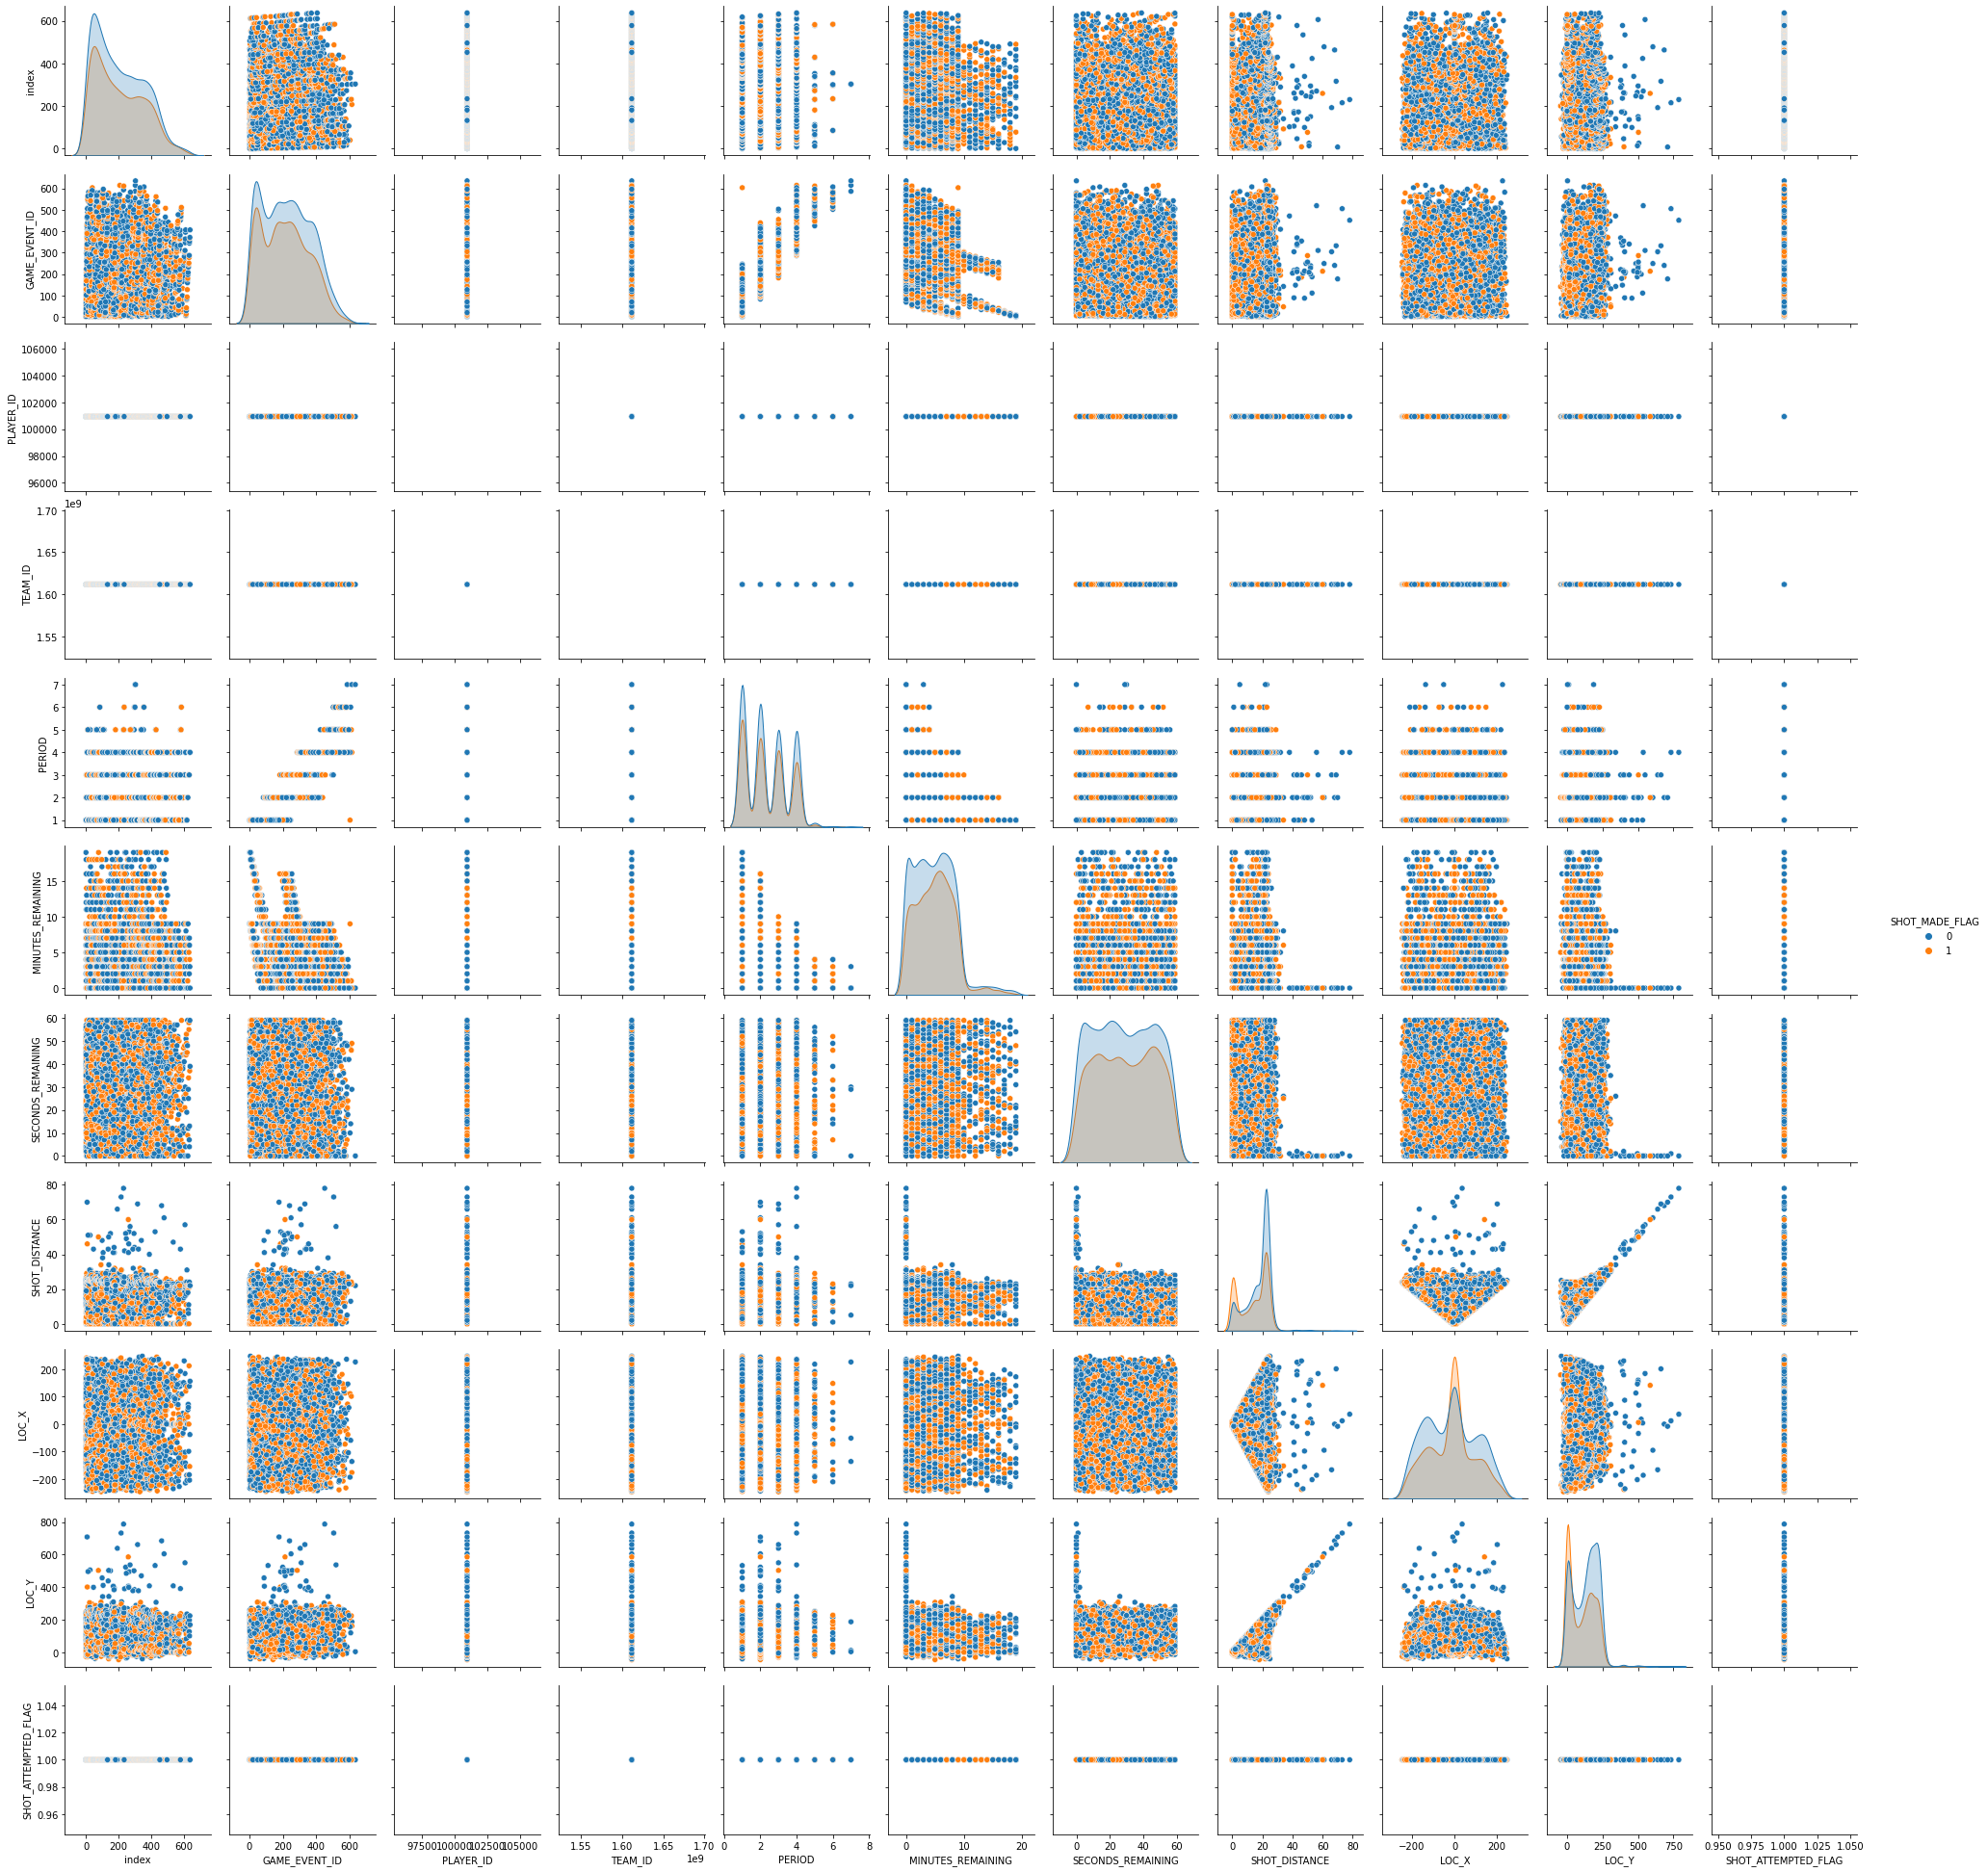

In [41]:
sns.pairplot(df2, hue='SHOT_MADE_FLAG')